# Fitting Notebook
Here we fit the phi-distributions from the analysis notebook.
- Model selection
- Fits of $\phi$
- MC study of fitting procedure

In [166]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('font', size=18)

In [167]:
data = pd.read_csv('results/phi-dist.csv')

In [168]:
data.columns

Index([u'axis', u'axis_bin', u'axis_max', u'axis_min', u'counts_neg',
       u'counts_pos', u'phi', u'phi_bin', u'stat', u'sys_0', u'value',
       u'global_index', u'sys_1', u'sys_10', u'sys_11', u'sys_2', u'sys_3',
       u'sys_4', u'sys_5', u'sys_6', u'sys_7', u'sys_8', u'sys_9',
       u'sys_total'],
      dtype='object')

In [169]:
data.head()

,axis,axis_bin,axis_max,axis_min,counts_neg,counts_pos,phi,phi_bin,stat,sys_0,...,sys_11,sys_2,sys_3,sys_4,sys_5,sys_6,sys_7,sys_8,sys_9,sys_total
0,x,0,0.150192,0.106729,16436,16311,-165.0,0,0.005526,0.000153,...,0.012388,0.000382,0.006687,0.003003,0.000823,0.001769,0.004440,0.001737,0.001579,0.016184
1,x,0,0.150192,0.106729,5994,5694,-135.0,1,0.009244,0.001028,...,0.036935,0.000559,0.007469,0.002108,0.006159,0.004268,0.007956,0.001319,0.008234,0.046834
2,x,0,0.150192,0.106729,12239,11837,-105.0,2,0.006443,0.000669,...,0.009165,0.000639,0.009500,0.010151,0.000039,0.008598,0.003775,0.002740,0.002257,0.025650
3,x,0,0.150192,0.106729,5800,5776,-75.0,3,0.009294,0.000083,...,0.007065,0.000468,0.008975,0.007215,0.001219,0.006447,0.010675,0.004319,0.003017,0.024239
4,x,0,0.150192,0.106729,4752,4481,-45.0,4,0.010399,0.001176,...,0.014624,0.000750,0.011015,0.005194,0.002070,0.005907,0.010280,0.001377,0.008271,0.024337


In [170]:
def chi2(y_true, y_pred, y_err):
    return np.sum((y_true-y_pred)**2/y_err**2)

In [171]:
class Model(object):

    def __init__(self):
        self.n_pars = 1
        self.pars   = np.zeros(shape=(self.n_pars, 1))
        self.bounds = np.array([[-1, 1],], dtype=np.float32)
        
    def get_initial_parameters(self):
        self.pars = np.random.uniform(-1.0, 1.0, size=(self.n_pars, 1))

    def evaluate(self, x):
        return 1.0

class SineModel(Model):

    def __init__(self):
        Model.__init__(self)
        self.n_pars = 1
        self.pars = np.zeros(shape=(self.n_pars, 1), dtype=np.float32)
        
    def evaluate(self, x):
        return self.pars[0]*np.sin( x*np.pi/180.0 )

class FullModel(Model):

    def __init__(self):
        Model.__init__(self)
        self.n_pars = 3
        self.pars = np.zeros(shape=(self.n_pars, 1), dtype=np.float32)
        self.bounds = np.array([[-1,1],
                                [-1,1],
                                [-1,1]],dtype=np.float32)
    def evaluate(self, x):
        return self.pars[0]*np.sin( x*np.pi/180.0 ) / (1 + self.pars[1]*np.cos(x*np.pi/180.0) + self.pars[2]*np.cos(2*x*np.pi/180.0))

def update_model(model, pars, x):
    model.pars = pars
    return model.evaluate(x)

In [172]:
from scipy.optimize import minimize

In [173]:
model = FullModel()
model.get_initial_parameters()

In [174]:
test_data = data.query('axis == "z" and axis_bin == 2')

In [175]:
test_data

,axis,axis_bin,axis_max,axis_min,counts_neg,counts_pos,phi,phi_bin,stat,sys_0,...,sys_11,sys_2,sys_3,sys_4,sys_5,sys_6,sys_7,sys_8,sys_9,sys_total
96,z,2,0.571011,0.514184,17708,17810,-165.0,0,0.005306,0.000115,...,0.009167,0.000768,0.005322,0.002135,0.000315,0.004526,0.007335,0.002025,0.001209,0.014957
97,z,2,0.571011,0.514184,8581,8384,-135.0,1,0.007677,0.000465,...,0.006443,0.001482,0.002218,0.006442,0.000776,0.009910,0.001650,0.001492,0.003092,0.014355
98,z,2,0.571011,0.514184,10913,10471,-105.0,2,0.006836,0.000828,...,0.001785,0.004938,0.001142,0.004960,0.000099,0.002183,0.000284,0.001238,0.007271,0.016668
99,z,2,0.571011,0.514184,8514,8183,-75.0,3,0.007736,0.000794,...,0.002600,0.003359,0.002712,0.002760,0.000230,0.007114,0.006405,0.002123,0.004510,0.016133
100,z,2,0.571011,0.514184,4391,4144,-45.0,4,0.010816,0.001159,...,0.008904,0.003290,0.007851,0.006677,0.001923,0.009447,0.004084,0.002524,0.005561,0.021236
101,z,2,0.571011,0.514184,1693,1604,-15.0,5,0.017404,0.001081,...,0.016251,0.005638,0.013812,0.016507,0.003297,0.016742,0.006336,0.006371,0.020773,0.041360
102,z,2,0.571011,0.514184,1630,1619,15.0,6,0.017544,0.000136,...,0.023111,0.007916,0.015051,0.006687,0.003104,0.020578,0.033875,0.012754,0.006947,0.053236
103,z,2,0.571011,0.514184,4298,4288,45.0,7,0.010792,0.000047,...,0.009828,0.004312,0.009414,0.005216,0.003389,0.004035,0.002663,0.001242,0.003191,0.023723
104,z,2,0.571011,0.514184,8100,8340,75.0,8,0.007798,0.000585,...,0.003861,0.003732,0.001199,0.003802,0.000094,0.004396,0.001031,0.001239,0.006674,0.016071
105,z,2,0.571011,0.514184,10301,10987,105.0,9,0.006847,0.001291,...,0.005616,0.002102,0.002549,0.005933,0.000225,0.015431,0.011103,0.000428,0.001775,0.021499


In [176]:
r = minimize(fun=lambda x: chi2(test_data.value, update_model(model, x, test_data.phi), test_data.stat), 
             x0=model.pars,
            bounds=model.bounds)

In [177]:
r

      fun: 19.592845625107486
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  3.02691205e-04,   3.90798505e-06,   3.09086090e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 152
      nit: 32
   status: 0
  success: True
        x: array([ 0.0175348 ,  0.30037367,  0.48921477])

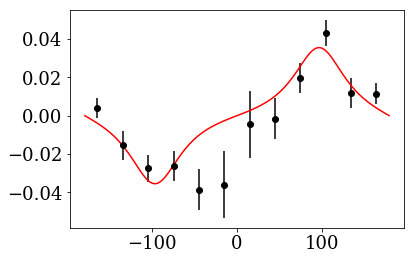

In [178]:
plt.errorbar(x=test_data.phi, y=test_data.value, yerr=test_data.stat,
            linestyle='', color='black', marker='o')
plt.plot(np.linspace(-180,180,100), model.evaluate(np.linspace(-180,180,100)), 
        linestyle='-', color='red')

In [179]:
from sklearn.utils import shuffle

def setup_dataframe(n_folds, x, y, y_err, shuf=False):
    
    if len(y) % n_folds != 0:
        print('Data (%d) is not divisible into %d folds.' % (len(y), n_folds))
        return 
    
    x = x.transpose()
    y = y.transpose()
    y_err = y_err.transpose()
    
    d  = {'x':x, 'y':y, 'y_err':y_err}
    df = pd.DataFrame(data=d)
    
    if shuf is True:
        df = shuffle(df)

    chunk_size = int(len(y)/n_folds) 
    
    a = np.arange(0,n_folds)
    df['chunk'] = np.repeat(a,chunk_size)
    return df

def cross_validate(n_folds, model, df):

    validation_scores = []
    parameters = []
    for i in range(n_folds):
        res = minimize(fun=lambda p: np.average((df.query('chunk != %d' % i).y - update_model(model, p, df.query('chunk != %d' % i).x))**2/df.query('chunk != %d' % i).y_err**2), 
                                    x0=model.pars, bounds=model.bounds
                                   )
        
        y_pred = update_model(model, res.x, df.query('chunk == %d' % i).x)
        validation_scores.append(np.average((df.query('chunk == %d' % i).y-y_pred)**2/df.query('chunk == %d' % i).y_err**2))
        parameters.append(res.x)
        
    return np.array(validation_scores), parameters

In [180]:
models = {}

models['basic'] = SineModel()
models['full'] = FullModel()
models['half'] = FullModel()
models['half'].bounds = np.array([[-1,1],[-1,1],[-0.0001,0.0001]], dtype=np.float32)

models['full_bounded'] = FullModel()
models['full_bounded'].bounds = np.array([[-1,1],[-0.1,0.1],[-0.1,0.1]], dtype=np.float32)
                                          
for m in models.values():
    m.get_initial_parameters()

In [181]:
CHUNKS = 3
df_chunked = setup_dataframe(CHUNKS, test_data.phi, test_data.value, np.sqrt(test_data.sys_total**2 + test_data.stat**2), shuf=False)

In [182]:
cv_scores = {}
cv_pars = {}

for name, m in models.iteritems():
    print('Fitting %s' % name)
    cv_scores[name], cv_pars[name] = cross_validate(CHUNKS, m, df_chunked)

Fitting full_bounded
Fitting half
Fitting full
Fitting basic


In [183]:
cv_scores

{'basic': array([ 0.1498727 ,  0.44172183,  0.24500724]),
 'full': array([ 0.20438262,  0.57750683,  0.32250448]),
 'full_bounded': array([ 0.2029939 ,  0.45877581,  0.2691167 ]),
 'half': array([ 0.20031067,  0.43944856,  0.30827155])}

In [184]:
cv_pars

{'basic': [array([ 0.02877499]), array([ 0.02655725]), array([ 0.02602331])],
 'full': [array([ 0.02910358,  0.12079579, -0.02865129]),
  array([ 0.01580644,  0.39035142,  0.50853674]),
  array([ 0.02375766, -0.25787141,  0.156954  ])],
 'full_bounded': [array([ 0.0293627 ,  0.1       , -0.04745232]),
  array([ 0.02471874,  0.07506849,  0.1       ]),
  array([ 0.02490738, -0.1       ,  0.1       ])],
 'half': [array([  2.87245333e-02,   1.37886941e-01,  -9.99999975e-05]),
  array([  2.66896624e-02,  -2.87568491e-02,   9.99999975e-05]),
  array([  2.58334134e-02,  -2.80538120e-01,   9.99999975e-05])]}

In [185]:
for k,v in cv_scores.iteritems():
    print(k, np.average(v))

('basic', 0.27886725670894247)
('full_bounded', 0.31029547129721519)
('full', 0.36813130675578104)
('half', 0.31601025836607283)


<Container object of 4 artists>

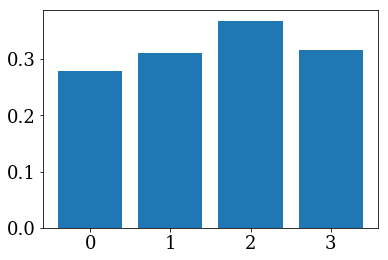

In [186]:
h = [np.average(xx) for xx in cv_scores.values()]
plt.bar(np.arange(len(cv_scores.keys())), height=h)

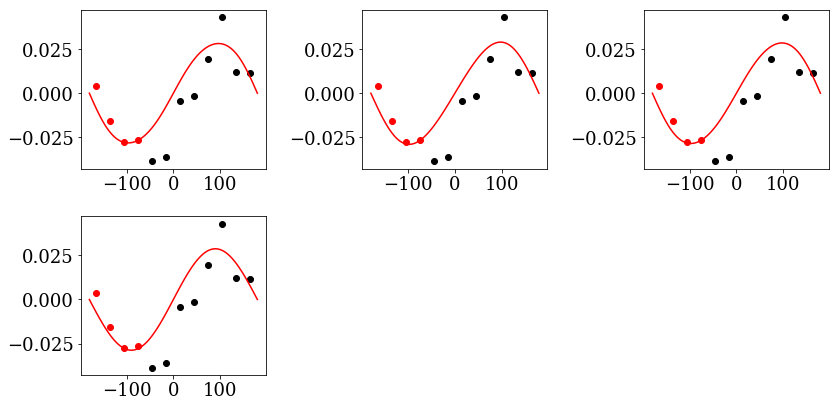

In [187]:
n_col = 3
n_row = np.ceil((len(cv_pars.keys())-1)/n_col)+1
plt.figure(figsize=(n_col*4, n_row*3))

train = df_chunked.query('chunk != 0')
test  = df_chunked.query('chunk == 0')

index = 1
x = np.linspace(-180,180,100)
for name, model in models.iteritems():
    plt.subplot(n_row, n_col, index)
    plt.plot(train.x, train.y, linestyle='', marker='o', color='black')
    plt.plot(test.x, test.y, linestyle='', marker='o', color='red')
    
    y = [update_model(model, cv_pars[name][0], xi) for xi in x]
    plt.plot(x, y, color='red')
    index += 1
    
plt.tight_layout()

In [188]:
def generate_toy_data(df, model):
    d = df.copy(deep=True)
    d.value = model.evaluate(d.phi) + np.random.normal(loc=0.0, scale=d.stat)
    return d

In [211]:
#models['full'].pars = [0.05, 0.02, -0.02]
models['basic'].pars = [0.065]
mc = generate_toy_data(test_data, models['basic'])

<Container object of 3 artists>

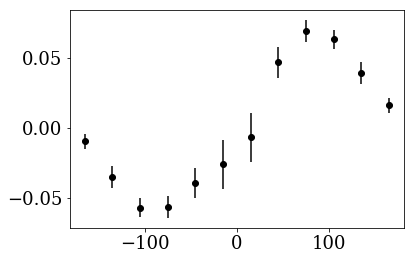

In [212]:
plt.errorbar(x=mc.phi, y=mc.value, yerr=mc.stat, color='black', 
            linestyle='', marker='o')

In [214]:
rmc = minimize(fun=lambda x: chi2(mc.value, update_model(models['full'], x, mc.phi), np.sqrt(mc.stat**2 + mc.sys_total**2)), 
             x0=models['full'].pars,
            bounds=models['full'].bounds)

In [215]:
rmc

      fun: 0.68779907691138908
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -2.55795385e-03,  -7.42406137e-05,  -3.93352018e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 112
      nit: 22
   status: 0
  success: True
        x: array([ 0.05676512, -0.09123842,  0.1161088 ])